In [1]:
import pandas as pd
import os
from utils import data_handlers
from pysentimiento import create_analyzer
from sentence_transformers import SentenceTransformer
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import spacy
from wordcloud import WordCloud


/home/ahdez929/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-23 22:01:42.858493: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 22:01:44.090005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740366104.397116   42023 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740366104.433967   42023 cuda_blas.cc:1418] Unable t

In [2]:
# transcriptions = data_handlers.load_transcriptions()
BASE_DIR = 'data/sentiment-analysis'
nlp = spacy.load('es_core_news_md')

In [3]:
def get_sentiment_analyzers():
    sentiment_analyzer = create_analyzer('sentiment', lang='es')
    emotion_analyzer = create_analyzer('emotion', lang='es')
    return sentiment_analyzer, emotion_analyzer

def get_bert_model():
    modelo_bert = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    return modelo_bert

def prepare_vectors(base_dir):
    data = pd.read_csv(
        os.path.join(base_dir, 'sentiment_emotion_mapping.csv'),
        header=None,
        skiprows=1,
        names=['letter', 'sentiment', 'emotion']
    )
    return data

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def load_file(base_dir, filename):
    content = ""
    with open(os.path.join(base_dir, filename), 'r') as f:
        content += f.read()
    return content

def evaluate_sentiment_model():
    sentiment, _ = get_sentiment_analyzers()
    # transcriptions = data_handlers.load_transcriptions()
    data = prepare_vectors(BASE_DIR)
    x_input = [load_file(os.path.join(BASE_DIR, 'manual-transcriptions'), x) for x in data['letter']]
    y_input = data['sentiment']
    predictions = [sentiment.predict(text).output for text in x_input]
    y_pred = [p for p in predictions]

    labels = sorted(list(set(y_input).union(set(y_pred))))

    accuracy = metrics.accuracy_score(y_input, y_pred)
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_input, y_pred, labels=labels)
    # logloss = log_loss(y_input, y_prob)

    print("Overall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    
    print("\nPer-class Metrics:")
    for i, label in enumerate(labels):
        print(f"\n{label}:")
        print(f"Precision: {precision[i]:.4f}")
        print(f"Recall: {recall[i]:.4f}")
        print(f"F1-score: {f1[i]:.4f}")

    plot_confusion_matrix(y_input, y_pred, labels, "Sentiment Analysis Confusion Matrix")

def get_sentiment_words():
    sentiment, _ = get_sentiment_analyzers()
    # transcriptions = data_handlers.load_transcriptions()
    data = prepare_vectors(BASE_DIR)
    x_input = [load_file(os.path.join(BASE_DIR, 'manual-transcriptions'), x) for x in data['letter']]
    y_input = data['sentiment']
    predictions = [sentiment.predict(text).output for text in x_input]
    y_pred = [p for p in predictions]

    labels = sorted(list(set(y_input).union(set(y_pred))))

    texts = {}

    for label in labels:
        texts[label] = ""

    for i, letter in enumerate(x_input):
        entities = extract_entities(letter)
        texts[y_pred[i]] += " ".join(entities)

    for label in labels:
        wordcloud = WordCloud(max_font_size=100, background_color = 'white')
        wordcloud.generate(texts[label])

        plt.figure()
        plt.title('Clase {}'.format(label))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

def evaluate_emotion_model():
    _, emotion = get_sentiment_analyzers()
    # transcriptions = data_handlers.load_transcriptions()
    data = prepare_vectors(BASE_DIR)
    x_input = [load_file(os.path.join(BASE_DIR, 'manual-transcriptions'), x) for x in data['letter']]
    y_input = data['emotion']
    predictions = [emotion.predict(text).output for text in x_input]
    y_pred = [p for p in predictions]
    
    labels = sorted(list(set(y_input).union(set(y_pred))))

    # Calculate metrics
    accuracy = metrics.accuracy_score(y_input, y_pred)
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_input, y_pred, labels=labels)

    # Print overall metrics
    print("Overall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Print per-class metrics
    print("\nPer-class Metrics:")
    for i, label in enumerate(labels):
        print(f"\n{label}:")
        print(f"Precision: {precision[i]:.4f}")
        print(f"Recall: {recall[i]:.4f}")
        print(f"F1-score: {f1[i]:.4f}")
        print(f"Support: {support[i]}")

    # Plot confusion matrix
    plot_confusion_matrix(y_input, y_pred, labels, "Emotion Analysis Confusion Matrix")

def embed_letter(model, letter_content):
    return model.encode(letter_content)

def clusterize_letters(n_clusters, letters, embeddings, y):
    pca = PCA(n_components=n_clusters)
    X = pca.fit_transform(embeddings)

    # Agrupar con K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    y_pred = kmeans.fit_predict(X)
    
    # Calcular la homogeneidad y la integridad de los clusters.
    homogeneity = metrics.homogeneity_score(y, y_pred)
    completeness = metrics.completeness_score(y, y_pred)
    
    # Calcular el coeficiente de coeficiente de Silhouette para cada muestra.
    s = metrics.silhouette_samples(X, y_pred)
    
    # Calcule el coeficiente de Silhouette medio de todos los puntos de datos.
    s_mean = metrics.silhouette_score(X, y_pred)
    
    # Para la configuración de los graficos -----------------------------------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    
    # Configura el gráfico.
    plt.suptitle('Silhouette analysis for K-Means clustering with n_clusters: {}'.format(n_clusters),
fontsize=14, fontweight='bold')
    
    # Configura el 1er subgrafico.
    ax1.set_title('Silhouette Coefficient for each sample')
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # Configura el 2do subgrafico.
    ax2.set_title('Homogeneity: {}, Completeness: {}, Mean Silhouette score: {}'.format(homogeneity,
                                                                                        completeness,
                                                                                        s_mean))
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    # Para el 1er subgráfico ------------------------------------------------------------------------------------------
    
    # Grafica el coeficiente de Silhouette para cada muestra.
    cmap = cm.get_cmap("Spectral")
    y_lower = 10
    for i in range(n_clusters):
        ith_s = s[y_pred == i]
        ith_s.sort()
        size_cluster_i = ith_s.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_s,
facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    # Trazar el coeficiente de silueta medio utilizando la línea discontinua vertical roja.
    ax1.axvline(x=s_mean, color="red", linestyle="--")
    
    # Para el 2do subgráfico ------------------------------------------------------------------------------------------
    
    # Grafica las predicciones
    colors = cmap(y_pred.astype(float) / n_clusters)
    ax2.scatter(X[:,0], X[:,1], c=colors)

    data = {
        'cluster': y_pred,
        'clase': y
    }

    df = pd.DataFrame(data)
    # Contar instancias por cluster y clase
    conteo = df.groupby(['cluster', 'clase']).size().reset_index(name='conteo')

    # Contar total de elementos por cluster
    totales_cluster = df['cluster'].value_counts().reset_index(name='total')
    totales_cluster.columns = ['cluster', 'total']

    # Calcular porcentajes
    porcentajes = conteo.merge(totales_cluster, on='cluster')
    porcentajes['porcentaje'] = (porcentajes['conteo'] / porcentajes['total']) * 100

    # Graficar
    plt.figure(figsize=(10, 6))
    sns.barplot(x='cluster', y='porcentaje', hue='clase', data=porcentajes, palette='viridis')

    plt.title('Porcentaje de clases dentro de cada cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Porcentaje (%)')
    plt.legend(title='Clase')
    plt.show()

    texts = {}

    for i in range(n_clusters):
        texts[i] = ""

    for i, item in enumerate(data['cluster']):
        entities = extract_entities(letters[i])
        texts[item] += " ".join(entities)

    for i in range(n_clusters):
        wordcloud = WordCloud(max_font_size=100, background_color = 'white')
        wordcloud.generate(texts[i])

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

def extract_entities(letter):
    doc = nlp(letter)
    entities = []
    ignore = ["Jose", "Usted", "de", "Martí", "Mañana", "Tu", "Dale", "Jos"]

    for ent in doc.ents:
        skip = False
        if ent.label_ == 'PER':
            for w in ignore:
                if w.lower() in ent.text.lower():
                    skip = True
                    break
        if not skip:
            entities.append(ent.text)
    return entities

/home/ahdez929/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Overall Metrics:
Accuracy: 0.6667

Per-class Metrics:

NEG:
Precision: 0.7143
Recall: 0.7895
F1-score: 0.7500

NEU:
Precision: 0.3529
Recall: 0.6667
F1-score: 0.4615

POS:
Precision: 0.8947
Recall: 0.5862
F1-score: 0.7083


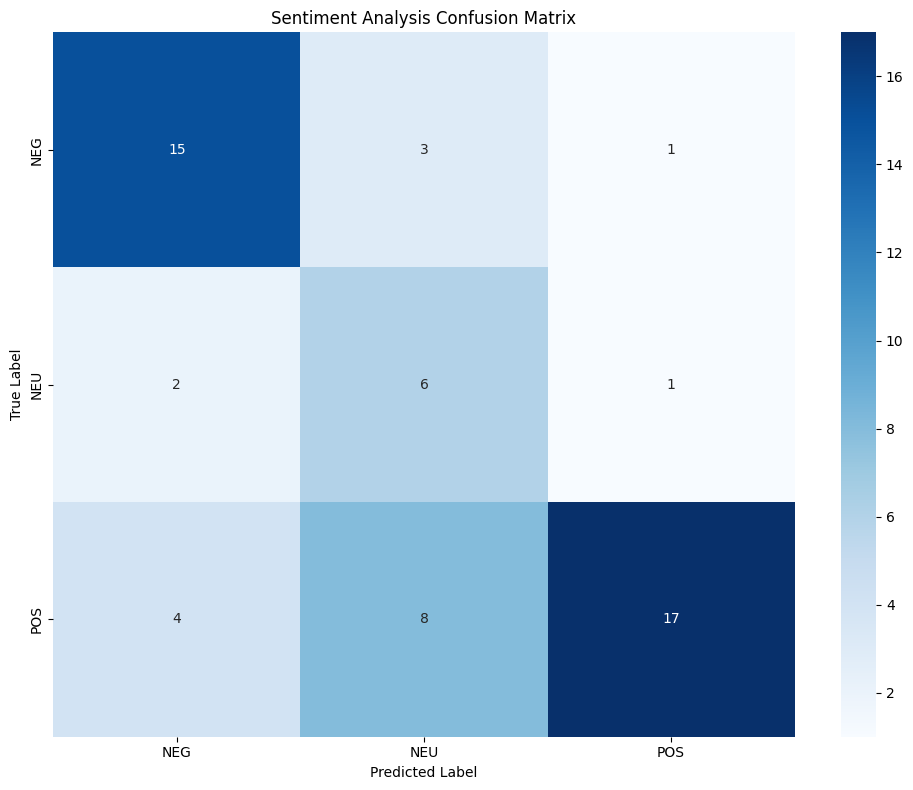

/home/ahdez929/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


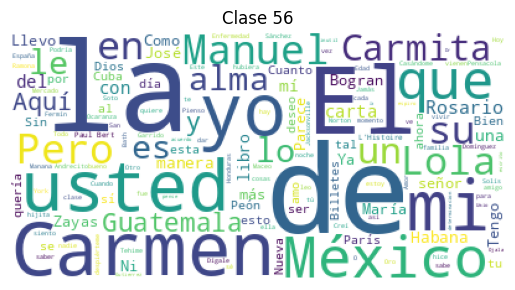

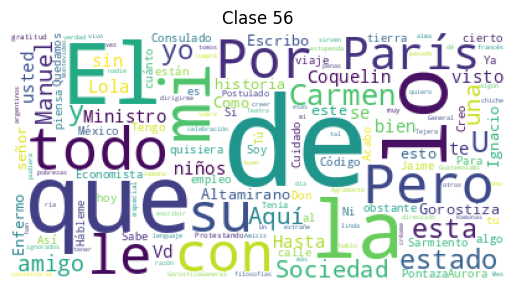

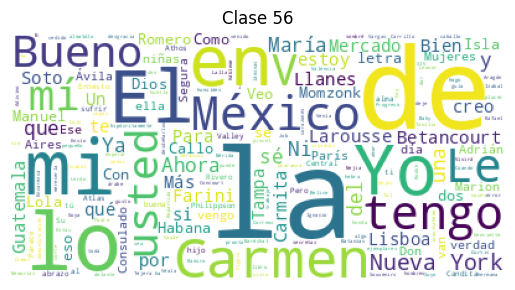

In [4]:
evaluate_sentiment_model()
get_sentiment_words()

/home/ahdez929/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Overall Metrics:
Accuracy: 0.4912

Per-class Metrics:

anger:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Support: 1

disgust:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Support: 2

fear:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Support: 2

joy:
Precision: 0.7000
Recall: 0.3500
F1-score: 0.4667
Support: 20

others:
Precision: 0.4286
Recall: 0.5000
F1-score: 0.4615
Support: 12

sadness:
Precision: 0.4839
Recall: 0.7500
F1-score: 0.5882
Support: 20


/home/ahdez929/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


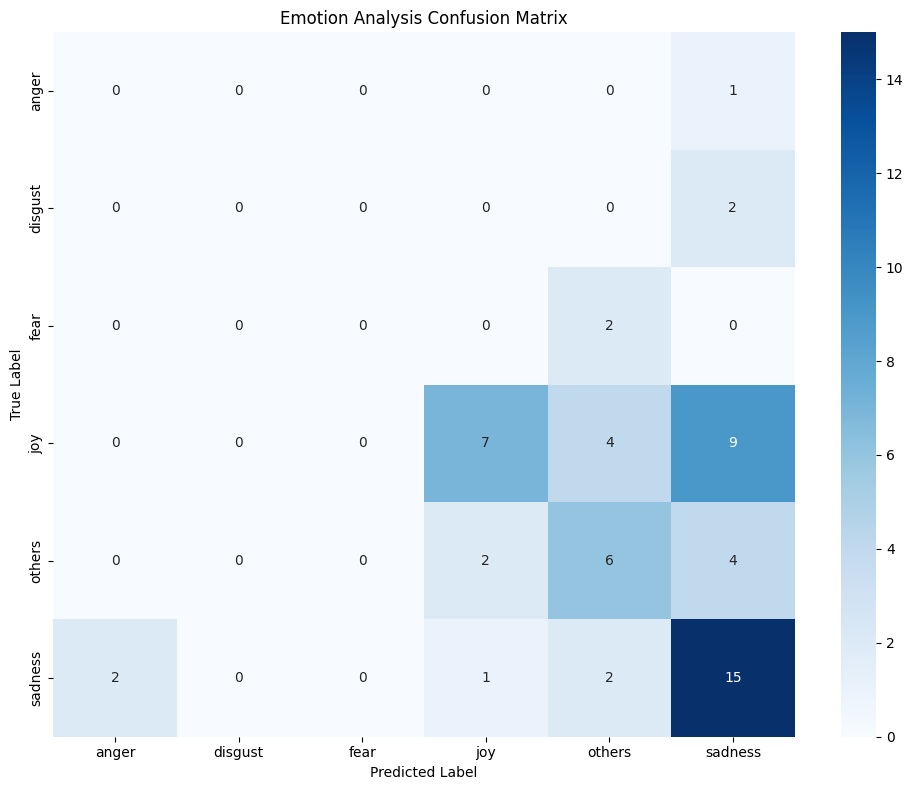

In [5]:
evaluate_emotion_model()

/home/ahdez929/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_42023/3477086204.py:171: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Spectral")


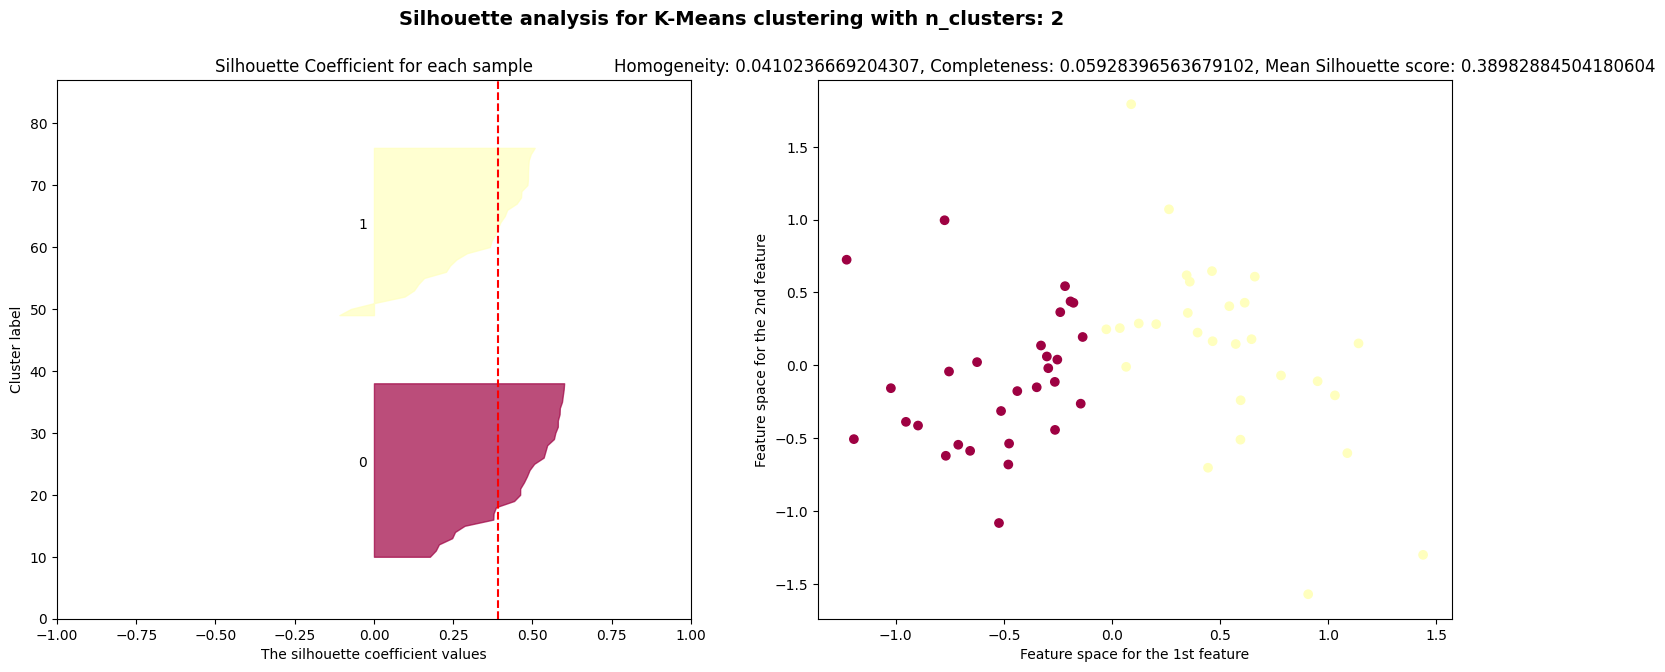

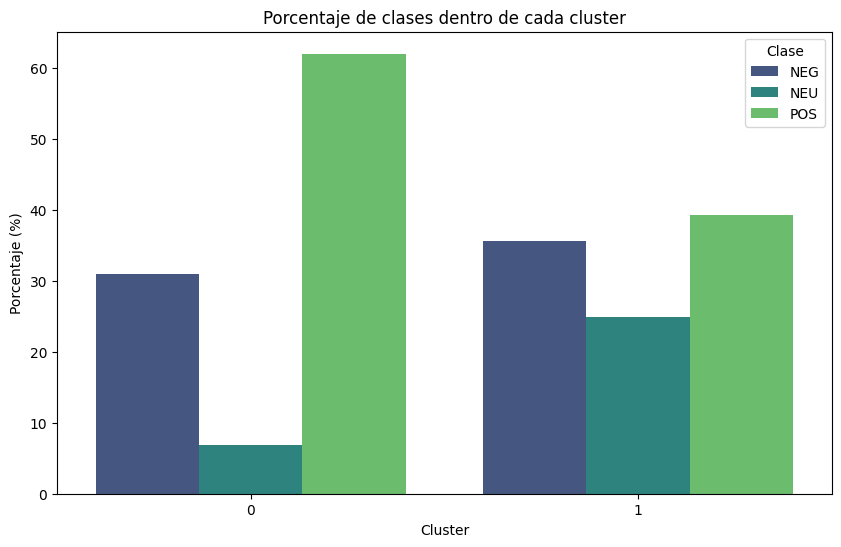

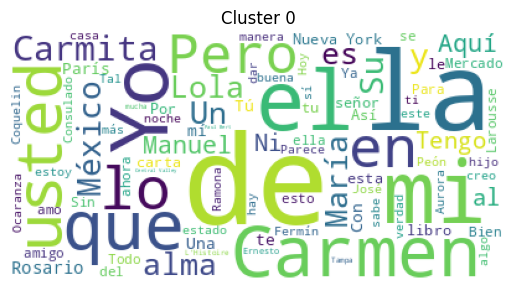

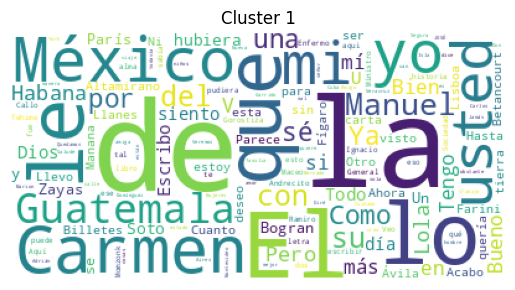

/tmp/ipykernel_42023/3477086204.py:171: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Spectral")


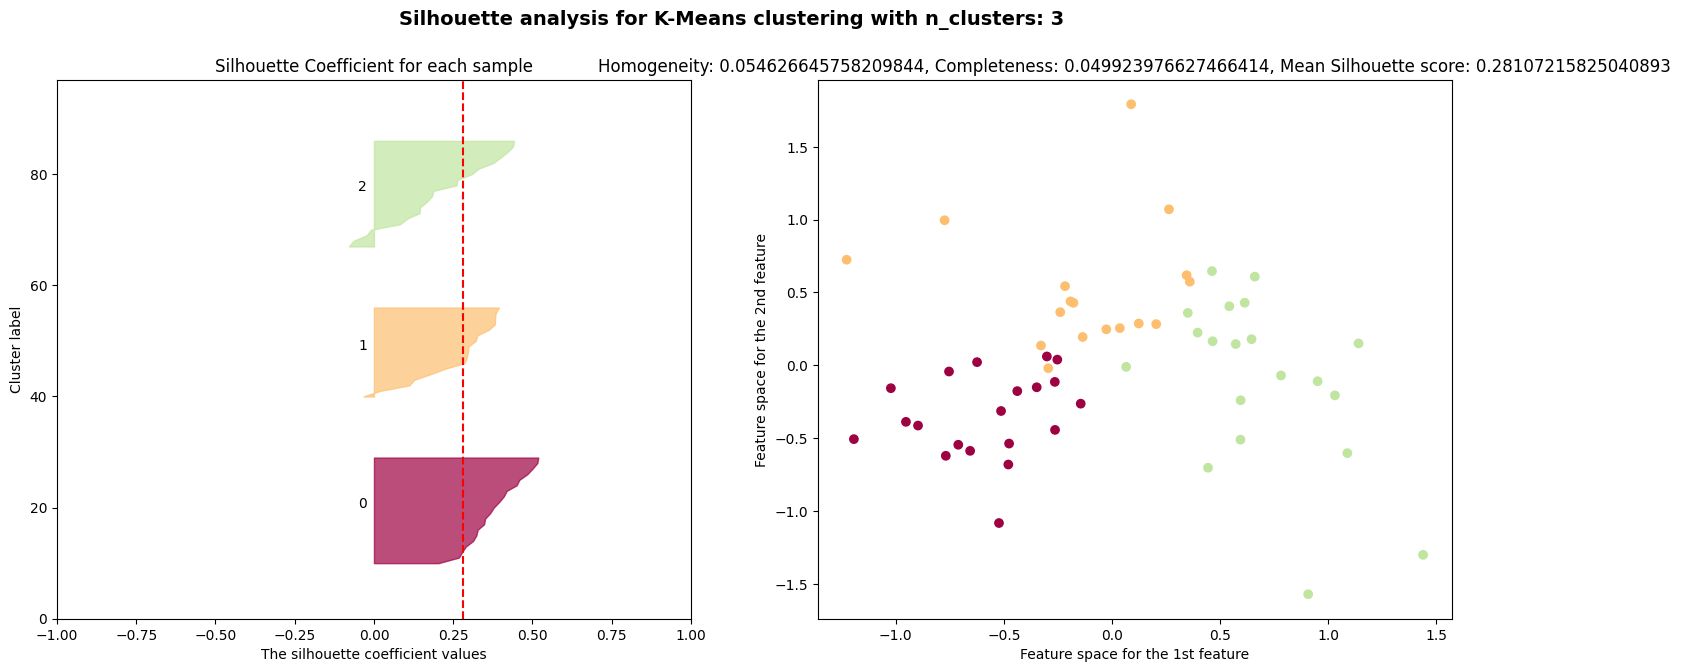

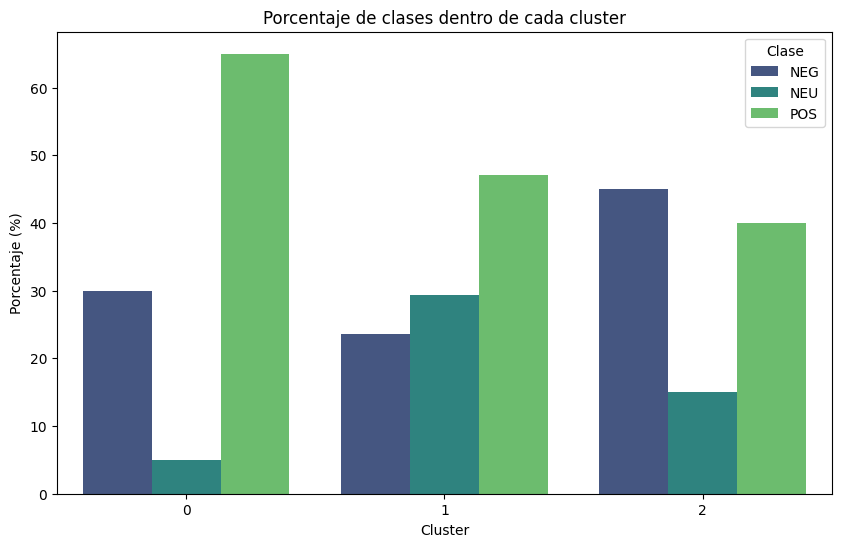

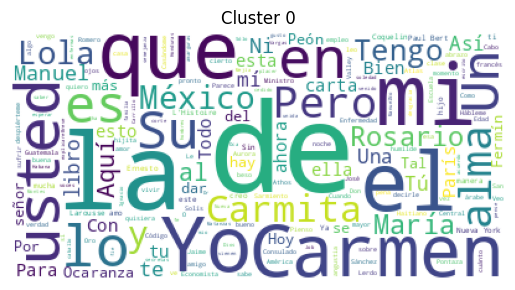

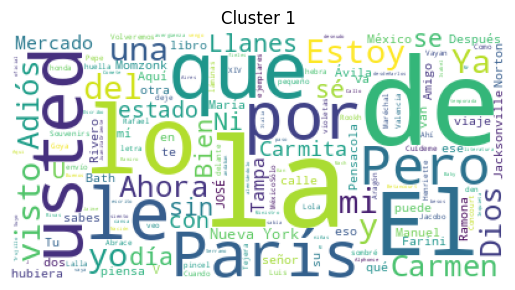

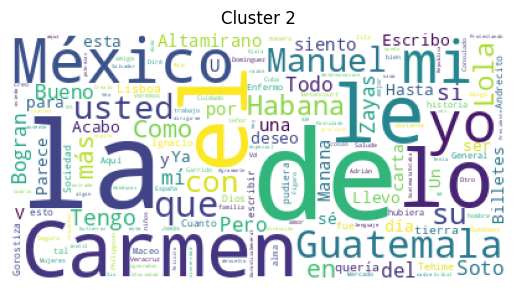

/tmp/ipykernel_42023/3477086204.py:171: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Spectral")


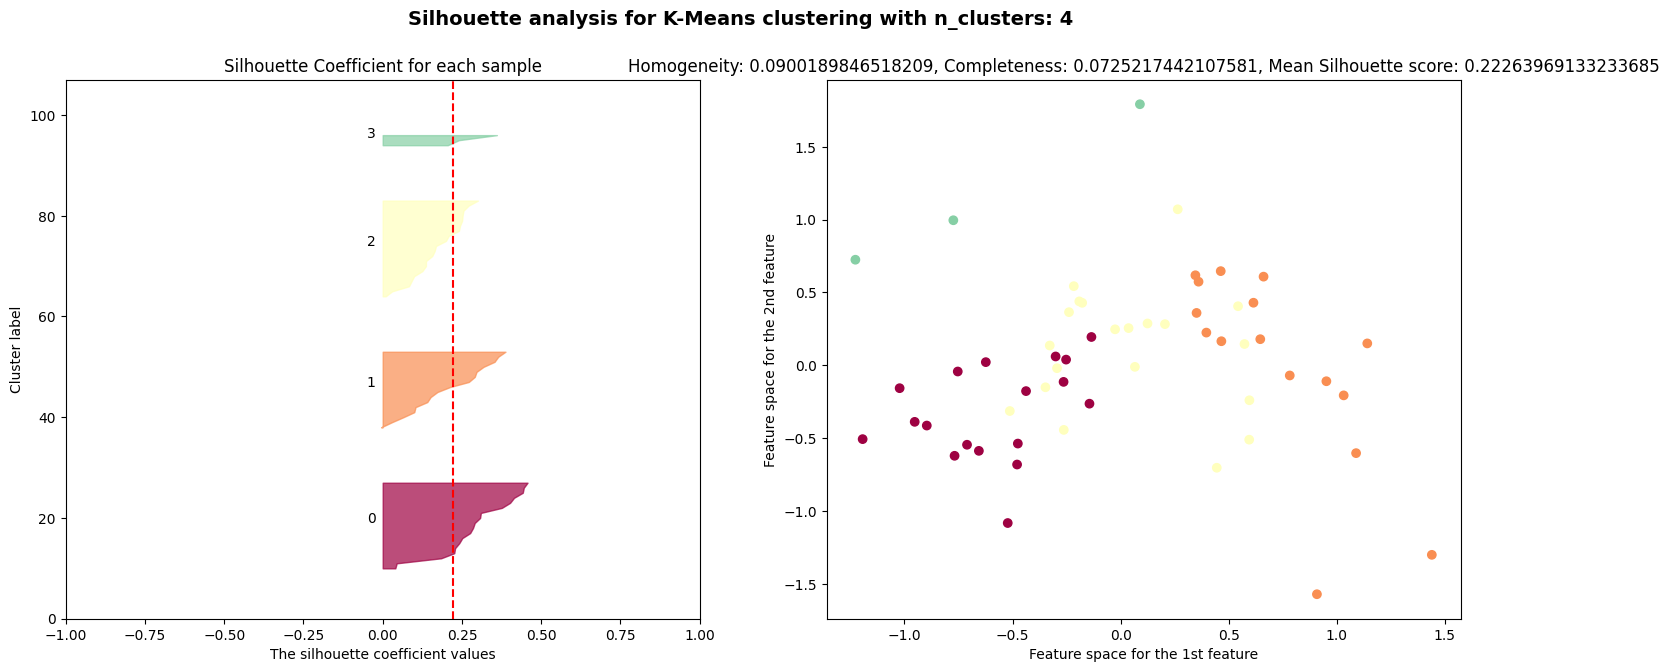

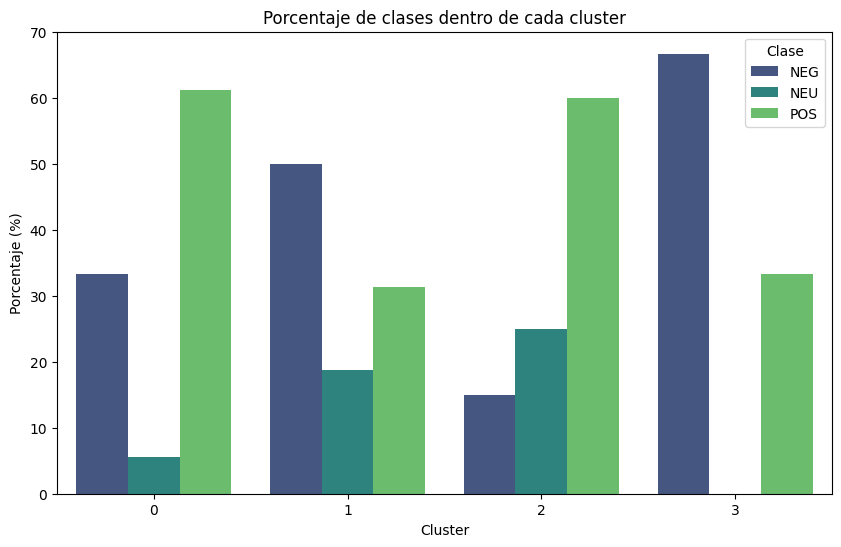

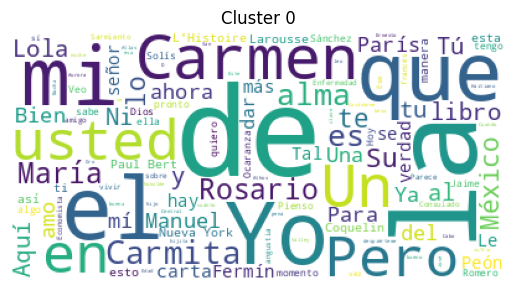

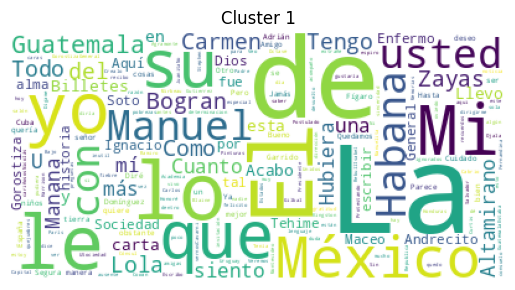

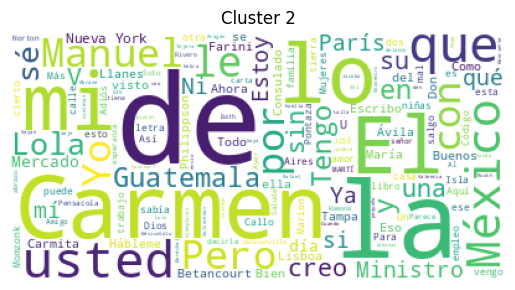

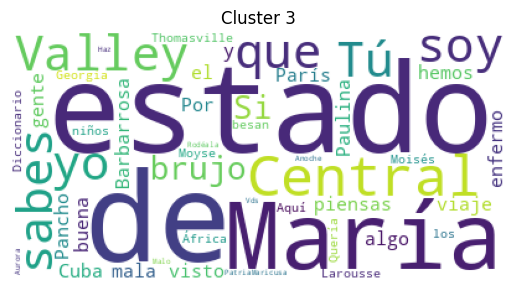

/tmp/ipykernel_42023/3477086204.py:171: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Spectral")


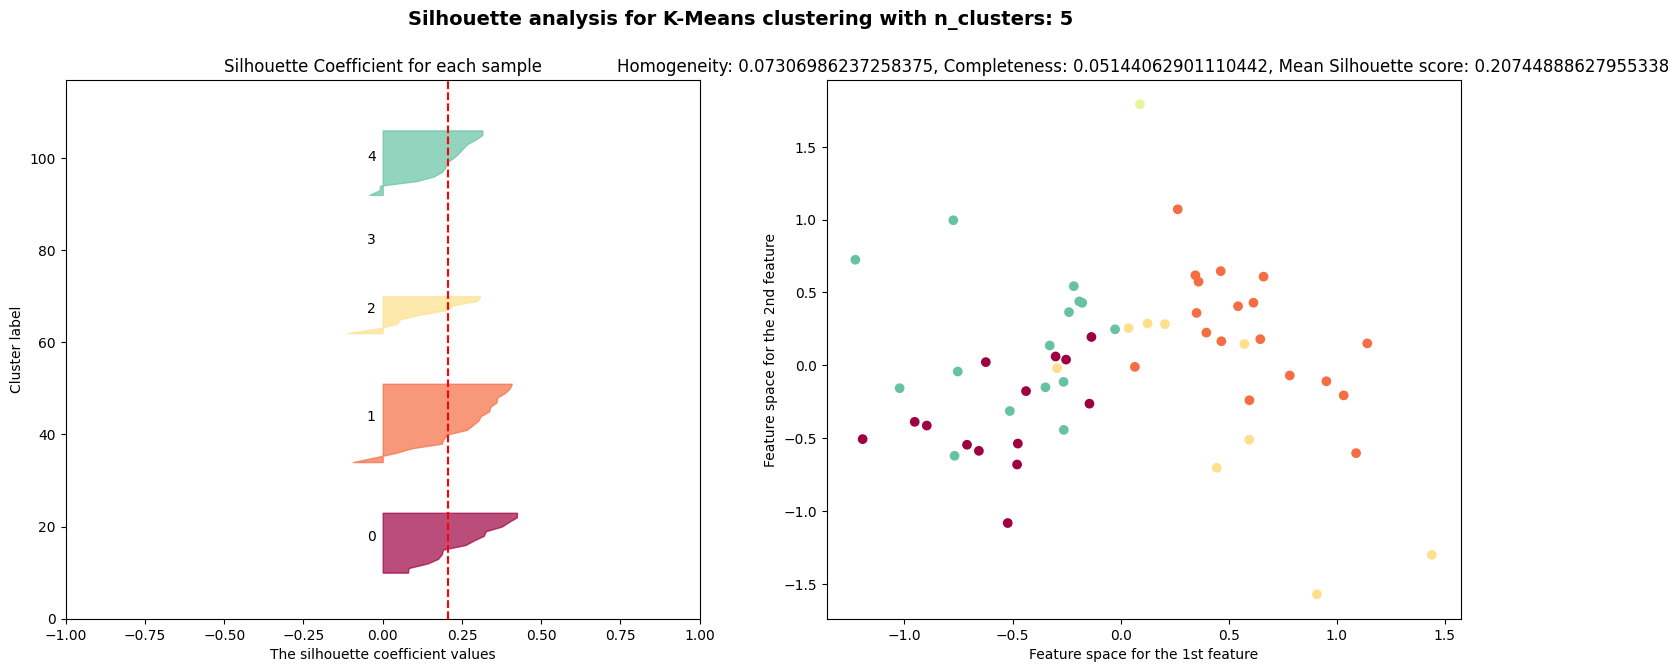

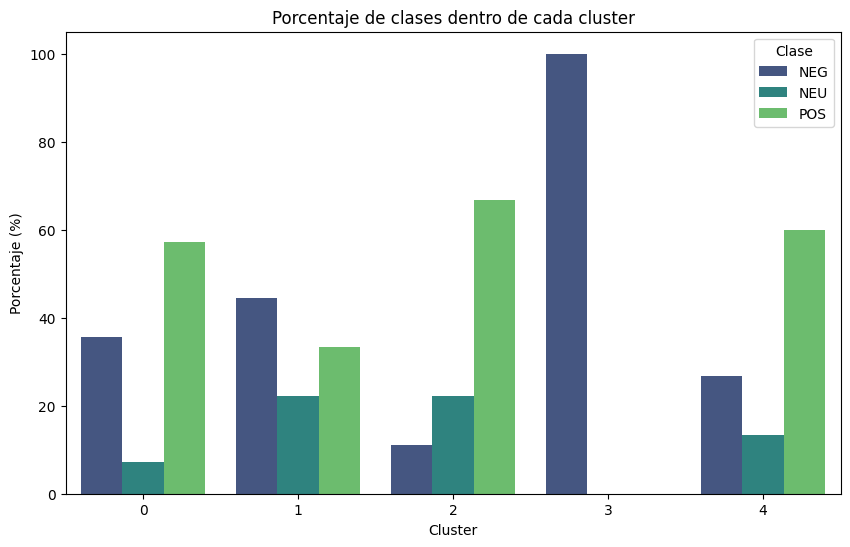

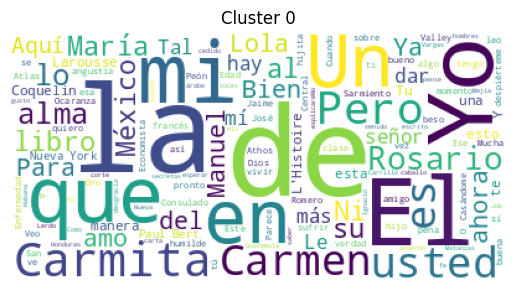

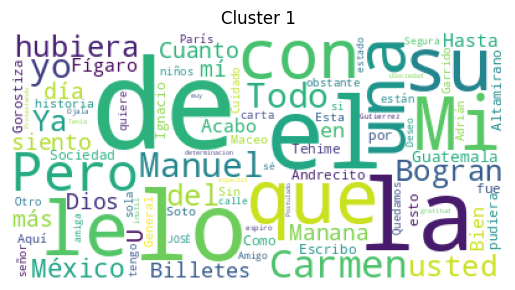

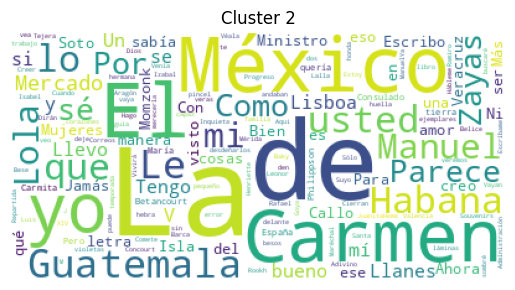

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [6]:
model = get_bert_model()
data = prepare_vectors(BASE_DIR)
letters = [load_file(os.path.join(BASE_DIR, 'manual-transcriptions'), x) for x in data['letter']]
embeddings = [embed_letter(model, letter) for letter in letters]

range_n_clusters = [2, 3, 4, 5, 6]
for i in range_n_clusters:
    clusterize_letters(i, letters, embeddings, data['sentiment'])
    


In [ ]:

for i, letter in enumerate(letters):
    entities = extract_entities(letter)
    print(data['letter'][i])
    print(entities)